In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
# Regression dataset - diabetes
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data.values
y = diabetes.target.values 

In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

So far, the diabetes dataset has been loaded, randomly divided into 80% training data and 20% percent test data and scaled. Different methods such as mini batch training or stochastic batches could have been used here, but there is really no need to change anything at this point.

In the following, the number of the clusters and the smoothness of each cluster m can be tuned. I decided to use a grid search to find a suitable combination of parameters, which can be found at the end of this notebook. 

Note that the targets are included in the training data and therefore act like an additional feature. Since we don't use clustering for unsupervised pattern recognition it is highly recommandable to do so, as it is very useful information and improves the performance, as seen in the comparison: The best result obtained including the targets is an MSE of 2476, without the targets it's only 2492. The effect might increase on bigger or complex data.

In [5]:
 # Number of clusters 
n_clusters = 4
m=1.1

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Comparison: without target
# Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [6]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

The following plot shows two out of ten features and their clustering. Since we cannot comprehend more than three (let alone ten) dimensions visually, it is obvious that the information in the plot is not complete. However, choosing suitable features, you can get reasonable results: Choosing the features BMI and blood pressure clearly leads to some causality. People with a high BMI seem to have higher blood pressure, whereas people with a low BMI tend to have lower blood pressure. It is likely, that the first group will also have a higher risk of diabetes, so this is indeed a reasonable clustering.
Opposing results can be found using non-correlating features such as gender (Feature 1) and age (Feature 0). Since there is no meaningful relation such as "if you are young, you are more likely to be a woman", the (visualization of the) data (and the clusters) does not give any helpful information.

Fuzzy partition coefficient (FPC): 0.9827491121401801


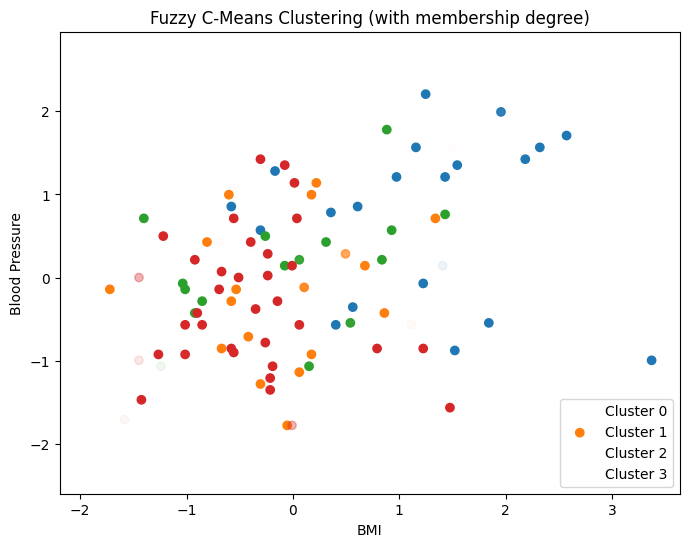

In [7]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        # Xexp[cluster_labels == j, 0],             # Feature 1 = Age
        # Xexp[cluster_labels == j, 1],             # Feature 2 = Gender
        Xexp[cluster_labels == j, 2],             # Feature 3 = BMI
        Xexp[cluster_labels == j, 3],             # Feature 4 = Blood Pressure
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("BMI")
plt.ylabel("Blood Pressure")
plt.legend()
plt.show()

The following plot projects the membership functions on a single feature, which, in other words, shows how easy separatable rules can explain the membership to a certain cluster. Using the BMI again you can easily separate the 4 curves. People with a high BMI have a high membership degree to the cluster on the right, which corresponds to people with a tendency to high blood pressure as well. Remember that there are still 8 (9 including the target) further features that affect the building of the clusters and might reason the choice of 4 clusters.

Using the gender as the chosen feature in this plot yields four almost similar curves, which tells you that the gender does not significantly influence the membership to a certain cluster. Therefore it could be a good idea to remove this feature for further calculations to reduce computational cost.

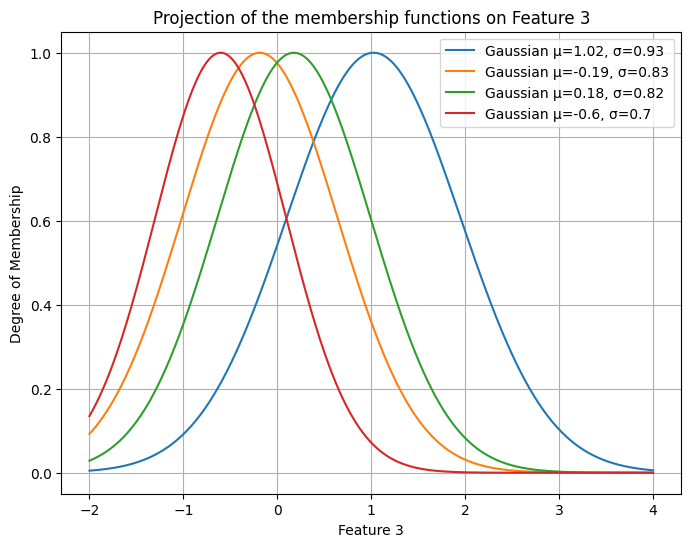

In [8]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):

# Select feature to be shown
    ft=3  # e.g. Feature 3 = BMI; Feature 2 = Gender
    fti=ft-1  # index correction

# Compute curves
    y_aux.append(gaussian(lin, centers[j,fti], sigmas[j,fti]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,fti],2)}, σ={np.round(sigmas[j,fti],2)}")

plt.title(f"Projection of the membership functions on Feature {ft}")
plt.xlabel(f"Feature {ft}")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [10]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)


In [11]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])
# model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers, sigmas=sigmas) # For comparison without target


Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

In [12]:
# Training with LS:
train_ls(model, Xtr, ytr.reshape(-1,1))

In the previous cells Fuzzy C-Means was used to initialize Gaussian membership functions (MFs) and a TSK (Takagi-Sugeno-Kang) model with Gaussian antecedents and linear consequents was built. The consequents were fit with a Least Squares solver and the model gets trained on the training data set. I did not change anything here, so I keep this comment short.

Finally, the accuracy gets tested as the mean squared error from the performance on the test data set. A lower MSE translates to a better performance.

In [13]:
y_pred, _, _=model(Xte)
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2476.77783203125


The following grid search method was implemented by MS Copilot. The results clearly suggest the clustering into 4 clusters.

Best grid-search result (lowest MSE):
n_clusters: 4, m: 1.1, mse: 2476.780273, fpc: 0.982749

Top 5 results:

n_clusters / m / mse / fpc

4 / 1.10 / 2476.780273 / 0.982749

4 / 1.50 / 2484.402832 / 0.915329

4 / 1.75 / 2489.548340 / 0.852930

4 / 1.30 / 2495.058350 / 0.952570

2 / 1.10 / 2522.157715 / 0.991280

In [14]:
# ---------------------------
# Grid search for optimal number of clusters and fuzzifier m
# ---------------------------
# Parameters requested by user
n_clusters_list = [2, 3, 4, 5, 6, 7, 8]
m_list = [1.1, 1.3, 1.5, 1.75, 2.0, 2.25, 2.5]

# Ensure required variables exist: Xtr, ytr, Xte, yte, TSK, train_ls
try:
    Xtr_np = Xtr.detach().numpy() if isinstance(Xtr, torch.Tensor) else np.array(Xtr)
    ytr_np = ytr.detach().numpy().reshape(-1, 1) if isinstance(ytr, torch.Tensor) else np.array(ytr).reshape(-1,1)
    Xte_np = Xte.detach().numpy() if isinstance(Xte, torch.Tensor) else np.array(Xte)
    yte_np = yte.detach().numpy().reshape(-1, 1) if isinstance(yte, torch.Tensor) else np.array(yte).reshape(-1,1)
except Exception as e:
    raise RuntimeError('Required tensors Xtr, ytr, Xte, yte are not defined or have wrong type') from e

results = []
import time
start_time = time.time()

# Use concatenated training input+target for clustering as in the notebook
Xexp = np.concatenate([Xtr_np, ytr_np], axis=1)
Xexp_T = Xexp.T

for n_c in n_clusters_list:
    for m_val in m_list:
        try:
            centers_tmp, u_tmp, u0, d, jm, p, fpc_tmp = fuzz.cluster.cmeans(
                Xexp_T, n_c, m=m_val, error=0.005, maxiter=1000, init=None
            )

            # Compute sigmas per cluster (weighted variance)
            sigmas_tmp = []
            for j in range(n_c):
                u_j = u_tmp[j, :] ** m_val
                var_j = np.average((Xexp - centers_tmp[j])**2, axis=0, weights=u_j)
                sigma_j = np.sqrt(var_j)
                sigmas_tmp.append(sigma_j)
            sigmas_tmp = np.array(sigmas_tmp)

            # Build TSK using only input dims (exclude appended target column)
            model_tmp = TSK(n_inputs=Xtr.shape[1], n_rules=n_c, centers=centers_tmp[:,:-1], sigmas=sigmas_tmp[:,:-1])

            # Train consequents with LS
            train_ls(model_tmp, torch.tensor(Xtr_np, dtype=torch.float32), torch.tensor(ytr_np, dtype=torch.float32))

            # Evaluate on test set
            y_pred_tmp, _, _ = model_tmp(torch.tensor(Xte_np, dtype=torch.float32))
            mse = mean_squared_error(yte_np, y_pred_tmp.detach().numpy())

            results.append({'n_clusters': n_c, 'm': m_val, 'mse': float(mse), 'fpc': float(fpc_tmp)})
            print(f'n_clusters={n_c}, m={m_val}, mse={mse:.6f}, fpc={fpc_tmp:.6f}')
        except Exception as e:
            print(f'Skipped n_clusters={n_c}, m={m_val} due to error: {e}')

# Summarize results
import pandas as pd
if len(results) == 0:
    print('Grid search produced no results')
else:
    df = pd.DataFrame(results)
    df_sorted = df.sort_values('mse')

    best = df_sorted.iloc[0]
    print('\nBest grid-search result (lowest MSE):')
    print(f"n_clusters: {int(best['n_clusters'])}, m: {best['m']}, mse: {best['mse']:.6f}, fpc: {best.get('fpc', np.nan):.6f}")

    print('\nTop 5 results:')
    print(df_sorted.head(5).to_string(index=False))

end_time = time.time()
print(f'Grid search finished in {end_time - start_time:.1f}s')


n_clusters=2, m=1.1, mse=2522.158691, fpc=0.991280
n_clusters=2, m=1.3, mse=2526.593506, fpc=0.967869
n_clusters=2, m=1.5, mse=2534.129150, fpc=0.939724
n_clusters=2, m=1.75, mse=2541.731201, fpc=0.898885
n_clusters=2, m=2.0, mse=2545.280029, fpc=0.855618
n_clusters=2, m=2.25, mse=2547.368408, fpc=0.814101
n_clusters=2, m=2.5, mse=2549.211670, fpc=0.776362
n_clusters=3, m=1.1, mse=2971.817139, fpc=0.986468
n_clusters=3, m=1.3, mse=2939.774170, fpc=0.955594
n_clusters=3, m=1.5, mse=2928.825195, fpc=0.921743
n_clusters=3, m=1.75, mse=2928.644043, fpc=0.868613
n_clusters=3, m=2.0, mse=2933.070312, fpc=0.807699
n_clusters=3, m=2.25, mse=2938.151855, fpc=0.746526
n_clusters=3, m=2.5, mse=2942.824219, fpc=0.689918
n_clusters=4, m=1.1, mse=2476.794434, fpc=0.982748
n_clusters=4, m=1.3, mse=2494.931885, fpc=0.952574
n_clusters=4, m=1.5, mse=2484.390869, fpc=0.915329
n_clusters=4, m=1.75, mse=2489.560547, fpc=0.852930
n_clusters=4, m=2.0, mse=2528.590332, fpc=0.780320
n_clusters=4, m=2.25, mse=